Case Study: SGD Exchange Rate analysis and prediction

In [93]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
warnings.filterwarnings("ignore")

df_orig = pd.read_csv(r"...\Foreign_Exchange_Rates.csv")
df_orig.head()


,DATE,SINGAPORE - SINGAPORE DOLLAR/US$,CHINA - YUAN/US$
0,1/3/2000,1.6563,8.2798
1,1/4/2000,1.6535,8.2799
2,1/5/2000,1.656,8.2798
3,1/6/2000,1.6655,8.2797
4,1/7/2000,1.6625,8.2794


In [94]:
# Preprocess the data and split it into train and test sets

# Replace 'ND' with NaN and drop any rows with NaN values
df = df_orig.replace('ND', pd.NA).dropna()

# Rename columns for ease of use
df = df.rename(columns={"SINGAPORE - SINGAPORE DOLLAR/US$": "rate_sgd", "DATE": "date", "CHINA - YUAN/US$": "rate_yuan"})

# Convert 'date' to datetime format and set it as index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Select only the Singapore Dollar rate column
df_sgd = df[['rate_sgd']].copy()

# Convert 'rate_sgd' to numeric, coercing errors
df_sgd['rate_sgd'] = pd.to_numeric(df_sgd['rate_sgd'], errors='coerce')

# Fill missing values by forward filling
df_sgd = df_sgd.asfreq('D').fillna(method='ffill')

# Split the dataset into training and testing sets
train = df_sgd.loc['2000-01-01':'2018-12-31']
test = df_sgd.loc['2019-01-01':'2019-12-31']

train.tail(), test.head() # Display the tail of the training set and the head of the test set to verify the split


(            rate_sgd
 date                
 2018-12-27    1.3713
 2018-12-28    1.3668
 2018-12-29    1.3668
 2018-12-30    1.3668
 2018-12-31    1.3623,
             rate_sgd
 date                
 2019-01-01    1.3623
 2019-01-02    1.3652
 2019-01-03    1.3637
 2019-01-04    1.3594
 2019-01-05    1.3594)

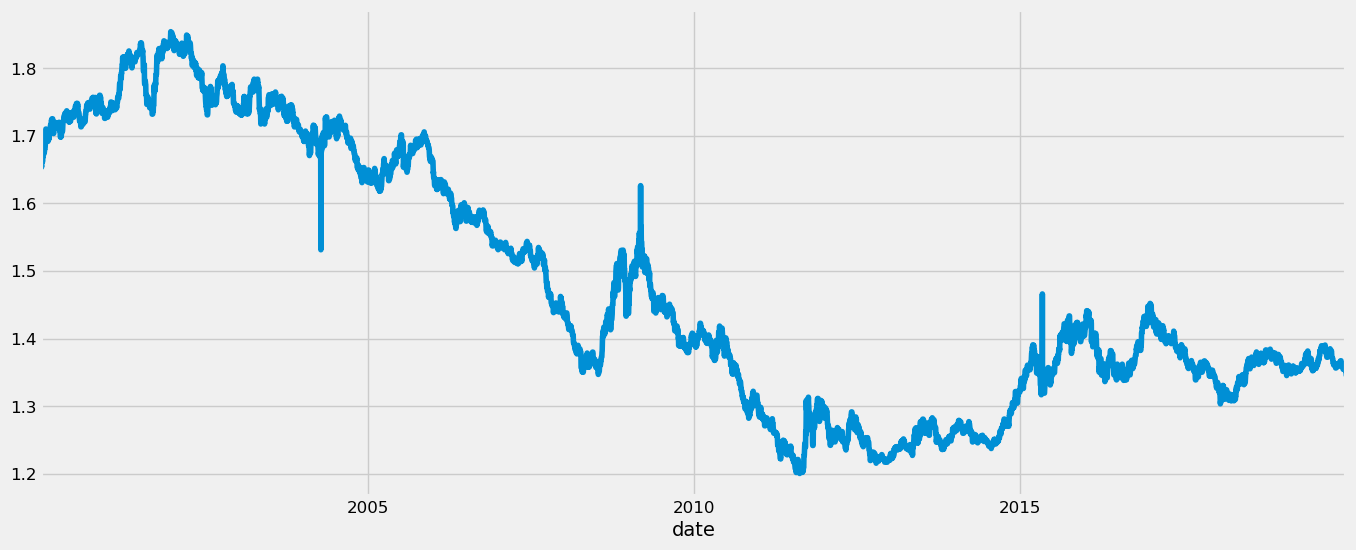

In [95]:
df_sgd['rate_sgd'].plot(figsize=(15, 6))
plt.show()

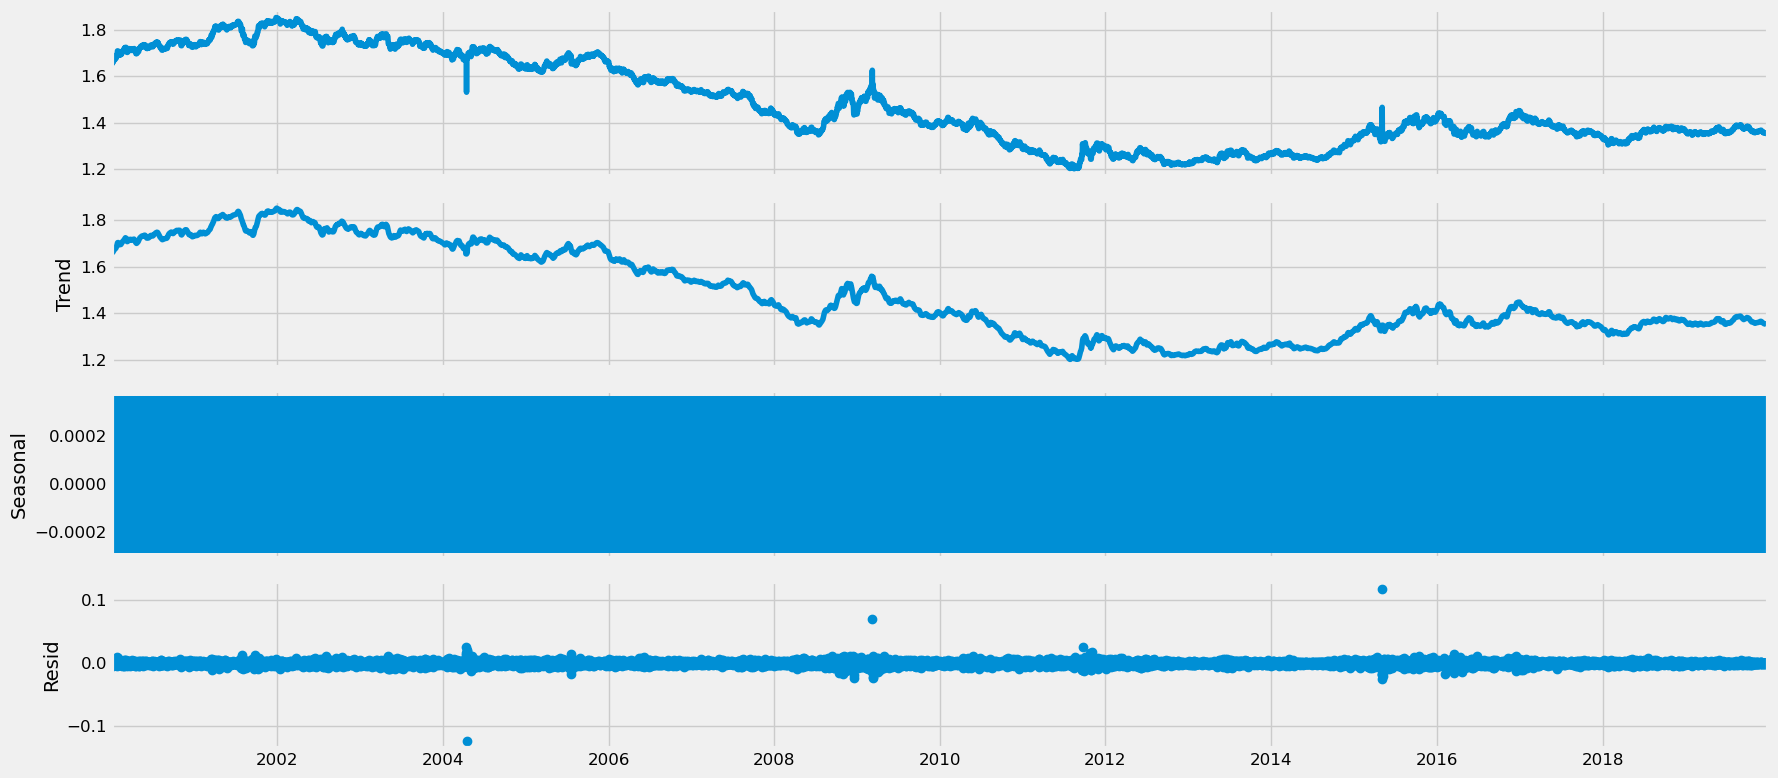

In [96]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
y = df_sgd.fillna(method='ffill')
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Observations of SGD rates for period 2000-2019:

The series is non-stationary as evidenced from the trend line. Historically, rates were the highest in the period dec'01-mar'02. The trend is decreasing till 2011 and then increases again. In this code, we will address this non-stationary nature of the dataset by setting "enforce_stationarity=False" in SARIMA implmentation.


In [97]:
# Check for stationarity and determine d value
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)
adf_statistic, p_value, usedlag, nobs, critical_values, icbest = result

# Display the results of the ADF test
adf_statistic, p_value, critical_values

(-0.9864680355908,
 0.7581677226858807,
 {'1%': -3.4312934269508233,
  '5%': -2.8619569182935014,
  '10%': -2.566991921705405})

The Augmented Dickey-Fuller (ADF) test results for the SGD series are as follows:

ADF Statistic: -0.98 p-value: 0.75 Critical Values: 1%: -3.43 5%: -2.86 10%: -2.57

The p-value is higher than the typical significance levels (0.05, 0.01), indicating that we cannot reject the null hypothesis that the series has a unit root, implying it is non-stationary. Before fitting an ARIMA model, we need to make the series stationary, typically by differencing.

Given this, we'll proceed with "enforce_stationarity=False" in SARIMA implementation.

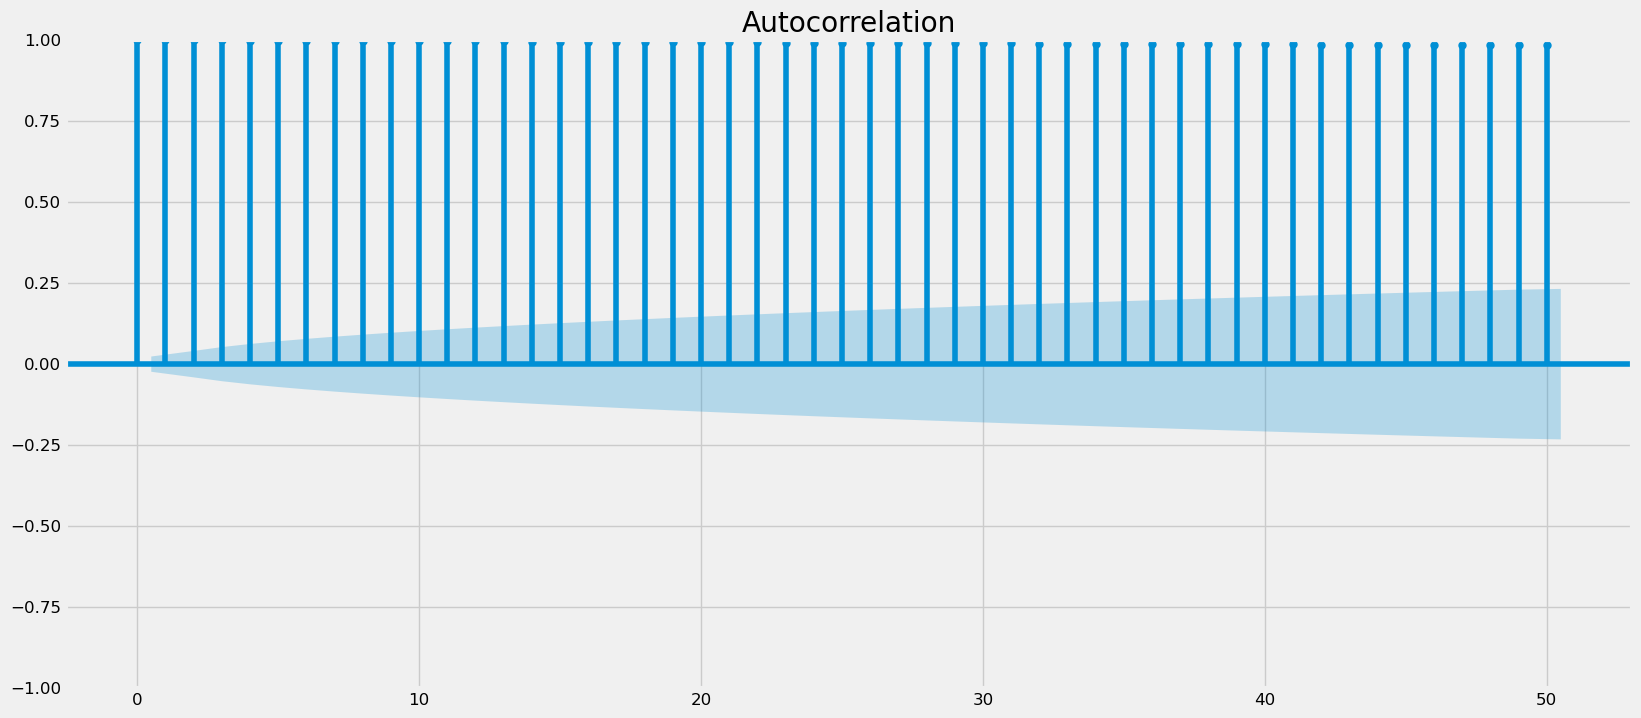

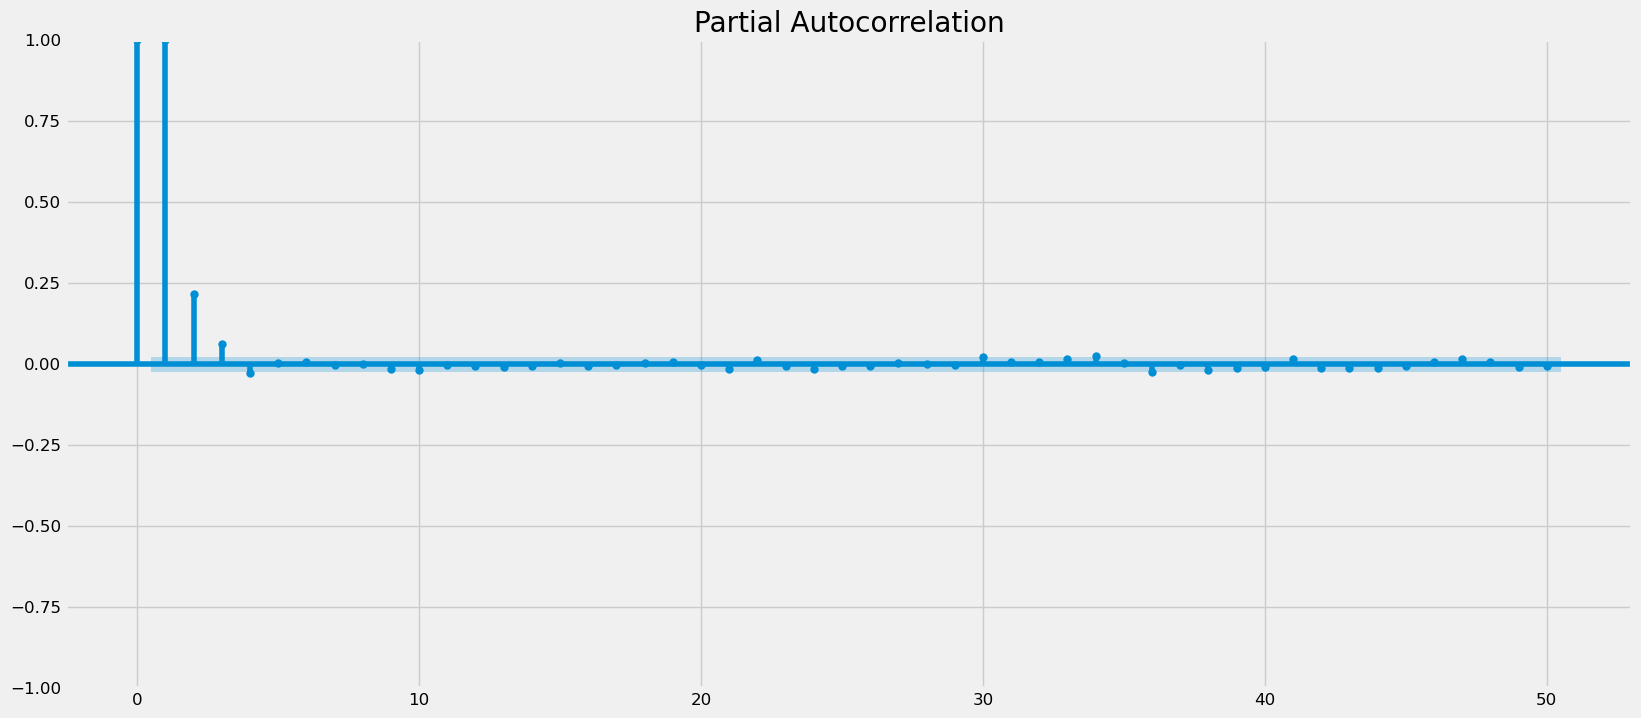

In [98]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
y_plt = train.values.reshape(-1)
plot_acf(y_plt, lags=50)
plot_pacf(y_plt, lags=50)
plt.show()

In [99]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [100]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:25300.20794473247
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:15799.87634634469
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-39194.7279935431
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-39129.41176233853
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-39209.18067856254
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-39202.71942008914
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-39134.5080430166
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-39130.42611783194
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:15733.948734263136
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6343.053069151487
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-43638.63035395207
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-43742.604438887494
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-43655.860197005386
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-43819.39449868323
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-43734.14879379403
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-43743.713701114655
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-52472.4866175199
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-52374.1838082

The above output suggests that SARIMAX(1, 0, 1)x(0, 0, 0, 12) yields the lowest AIC value of -52981.67. Therefore we should consider this to be optimal option.

In [101]:
# Fit the SARIMAX model on the training set
model = sm.tsa.statespace.SARIMAX(train,
                                  order=(1, 0, 1),
                                  seasonal_order=(0, 0, 0, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

results = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   3.05e-05   3.28e+04      0.000       1.000       1.000
ma.L1         -0.2780      0.001   -186.225      0.000      -0.281      -0.275
sigma2      2.813e-05   5.49e-08    512.562      0.000     2.8e-05    2.82e-05


P>|z| values of ar.L1 and ma.L1 are less than 0.05

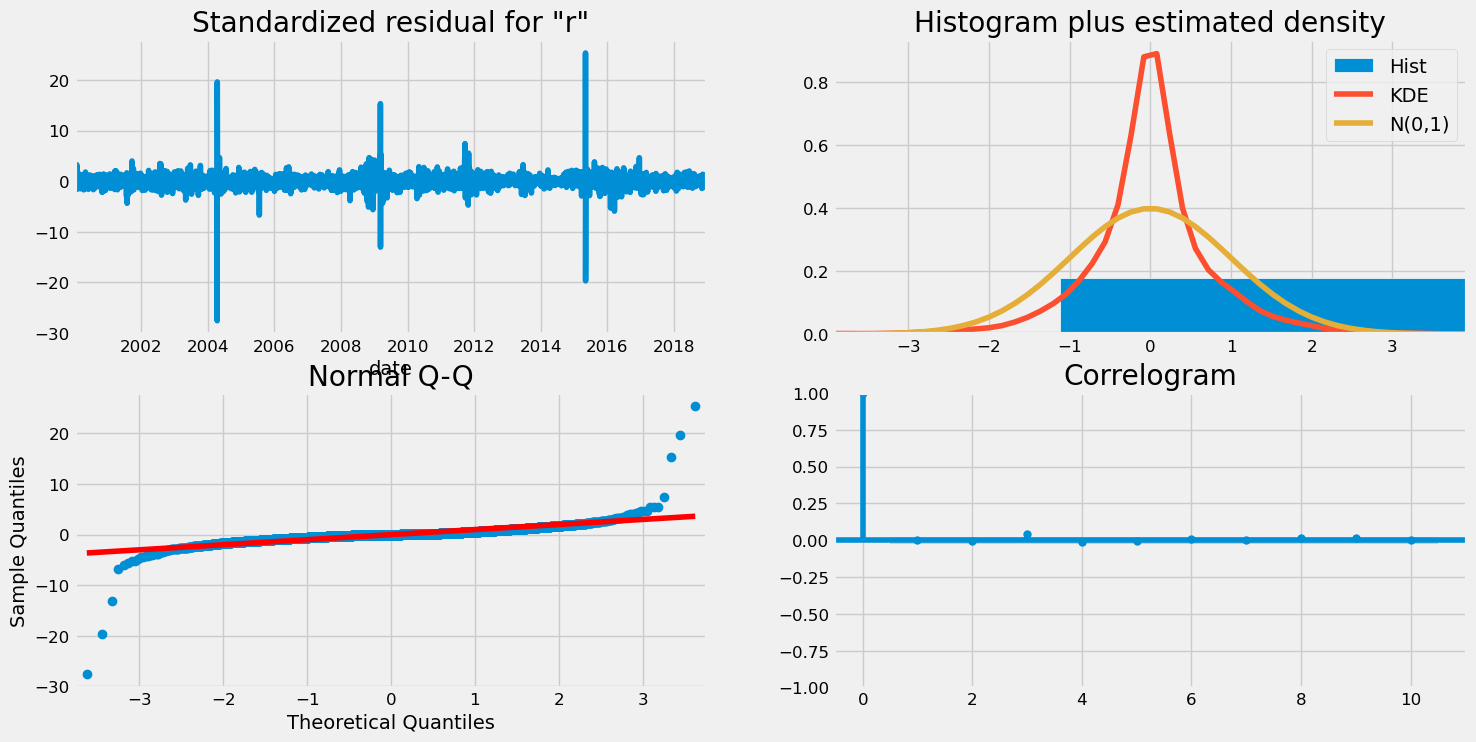

In [102]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [103]:
# Forecast for the year 2019
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_ci = pred.conf_int()

# Calculate MSE and RMSE for the forecasts
y_forecasted = pred.predicted_mean
y_truth = test['rate_sgd']

mse = ((y_forecasted - y_truth) ** 2).mean()
rmse = mse ** 0.5

mse, rmse, results.summary().tables[1]

(0.00024218231324500268,
 0.015562207852518956,
 <class 'statsmodels.iolib.table.SimpleTable'>)

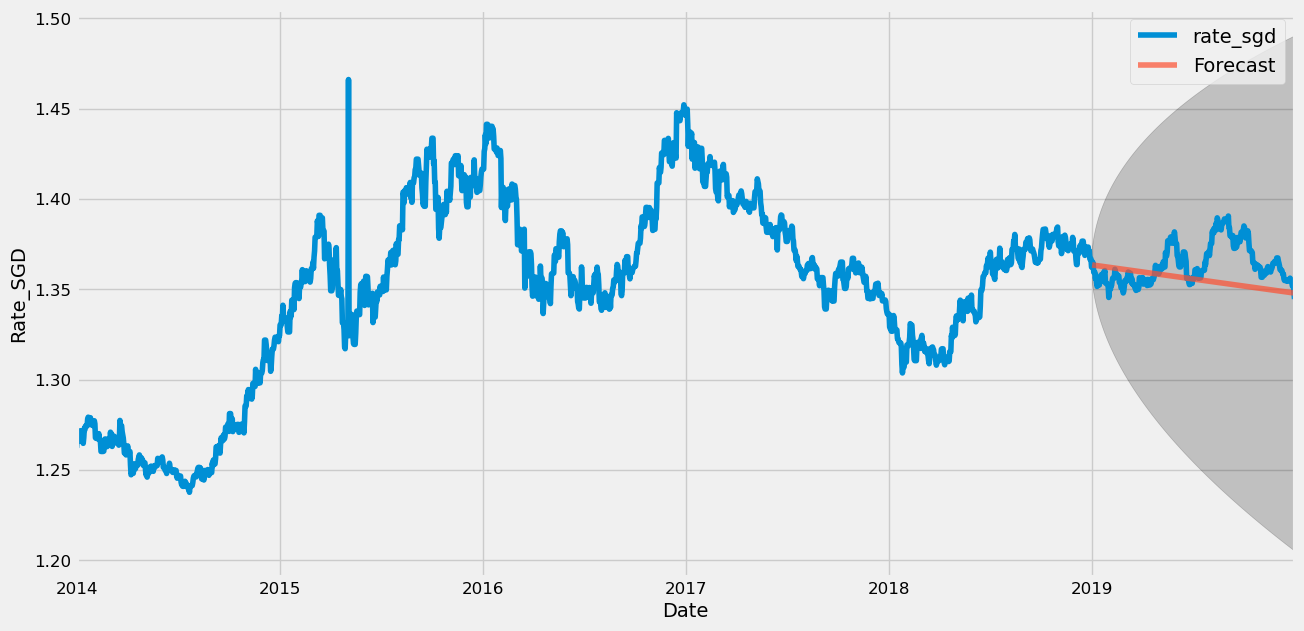

In [104]:
# Plotting
ax = df_sgd['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Rate_SGD')
plt.legend()
plt.show()

In [105]:
# Comparing different models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

# Define a function to calculate MSE and RMSE
def calculate_errors(y_true, y_pred):
    mse = ((y_pred - y_true) ** 2).mean()
    rmse = np.sqrt(mse)
    return mse, rmse

# Container for errors
errors = {}

# ARIMA Model
arima_model = ARIMA(train, order=(1, 0, 1))
arima_results = arima_model.fit()
arima_forecast = arima_results.predict(start=test.index[0], end=test.index[-1], typ='levels')
errors['ARIMA'] = calculate_errors(test['rate_sgd'], arima_forecast)

# SARIMA Model (re-using SARIMAX with the best parameters found previously)
sarima_forecast = pred.predicted_mean
errors['SARIMA'] = calculate_errors(test['rate_sgd'], sarima_forecast)

# Exponential Smoothing (ETS)
ets_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12)
ets_results = ets_model.fit()
ets_forecast = ets_results.predict(start=test.index[0], end=test.index[-1])
errors['ETS'] = calculate_errors(test['rate_sgd'], ets_forecast)

# Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(train)
ses_results = ses_model.fit()
ses_forecast = ses_results.predict(start=test.index[0], end=test.index[-1])
errors['SES'] = calculate_errors(test['rate_sgd'], ses_forecast)

errors


{'ARIMA': (0.00012364150330546834, 0.011119420097535138),
 'SARIMA': (0.00024218231324500268, 0.015562207852518956),
 'ETS': (0.00024171660629905393, 0.015547237899352216),
 'SES': (0.00011784526598274629, 0.010855655944379698)}

)}
Based on these results, both the ARIMA and Simple Exponential Smoothing (SES) models show the lowest MSE and RMSE, indicating a better performance on this dataset for the year 2019 compared to the SARIMA and ETS models. It's noteworthy that despite the simplicity of the SES model, it performs comparably to the more complex ARIMA model for this particular dataset and test-train split.

This comparison suggests that for the specific dynamics of this exchange rate data, simpler models like ARIMA and SES can provide effective forecasting performance. The choice between models would depend on the specific requirements for the forecast, including considerations of complexity, interpretability, and computational resources.

In [106]:
# LSTM implementation

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

# Reshape data for scaling: [samples, features]
data = df_sgd['rate_sgd'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Split the data into training and testing sets after scaling
train_size = len(train)
test_size = len(test)
train_scaled, test_scaled = data_scaled[0:train_size,:], data_scaled[train_size:train_size+test_size,:]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train_scaled, look_back)
testX, testY = create_dataset(test_scaled, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY_inv = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inv = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY_inv[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY_inv[0], testPredict[:,0]))

trainScore, testScore


Epoch 1/10
6936/6936 - 20s - loss: 0.0081 - 20s/epoch - 3ms/step
Epoch 2/10
6936/6936 - 12s - loss: 1.1077e-04 - 12s/epoch - 2ms/step
Epoch 3/10
6936/6936 - 10s - loss: 1.0793e-04 - 10s/epoch - 2ms/step
Epoch 4/10
6936/6936 - 20s - loss: 1.0727e-04 - 20s/epoch - 3ms/step
Epoch 5/10
6936/6936 - 13s - loss: 1.0619e-04 - 13s/epoch - 2ms/step
Epoch 6/10
6936/6936 - 9s - loss: 1.0416e-04 - 9s/epoch - 1ms/step
Epoch 7/10
6936/6936 - 16s - loss: 1.0216e-04 - 16s/epoch - 2ms/step
Epoch 8/10
6936/6936 - 19s - loss: 1.0134e-04 - 19s/epoch - 3ms/step
Epoch 9/10
6936/6936 - 10s - loss: 1.0015e-04 - 10s/epoch - 1ms/step
Epoch 10/10
6936/6936 - 9s - loss: 1.0081e-04 - 9s/epoch - 1ms/step
12/12 [==============================] - 0s 1ms/step


(0.00627309474143337, 0.002216295754456198)

In [107]:
# Export predictions
# Create a DataFrame with the dates and values
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': testY_inv.flatten(),  # Flatten in case it's a 2D array
    'Predicted': testPredict.flatten()
})

# Write the DataFrame to a CSV file
results_df.to_csv('test_predictions.csv', index=False)


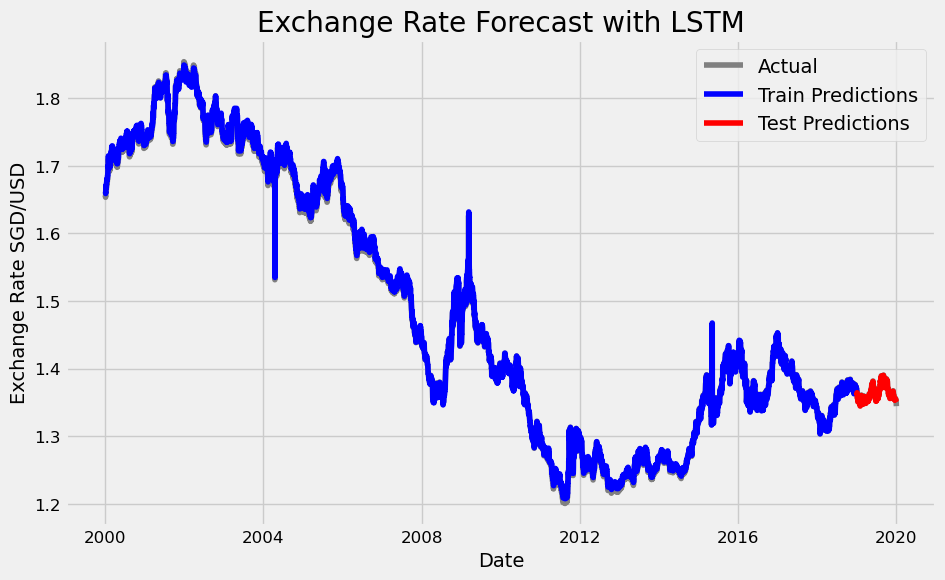

In [108]:
plt.figure(figsize=(10, 6))

# Convert the test dataset index to a suitable format if necessary
test_dates = pd.to_datetime(df_sgd.index[train_size:train_size+len(testPredict)])

# Plot original exchange rates
plt.plot(df_sgd.index, df_sgd['rate_sgd'], label='Actual', color='grey')

# Plot training predictions
train_pred_dates = pd.to_datetime(df_sgd.index[look_back:train_size-1])  # Adjusting for look_back
plt.plot(train_pred_dates, trainPredict, label='Train Predictions', color='blue')

# Plot test predictions
plt.plot(test_dates, testPredict, label='Test Predictions', color='red')

plt.title('Exchange Rate Forecast with LSTM')
plt.xlabel('Date')
plt.ylabel('Exchange Rate SGD/USD')
plt.legend()
plt.show()


Given the results and analysis of the various models (ARIMA, SARIMA, ETS, SES, and LSTM) for forecasting exchange rates, here are my recommendations:

Model Selection
LSTM's Performance: The LSTM model shows promising results, especially considering its test RMSE is lower than its training RMSE. This suggests good generalization to unseen data. Given the complexity and potential non-linear relationships in financial time series data, the LSTM model's ability to capture these dynamics makes it a strong candidate.
Comparative Analysis: When comparing the LSTM model's performance to traditional time series models (ARIMA, SARIMA, ETS, SES), it's crucial to consider the specific requirements of the forecasting task, including the need for interpretability, computational resources, and forecast horizon. Traditional models like ARIMA and SES showed lower RMSEs in earlier tests, which suggests they are also quite effective for this dataset.
Practical Considerations
Interpretability vs. Accuracy: If the primary goal is to achieve the best possible accuracy and you have the computational resources to train complex models, LSTM might be the way to go. However, if interpretability is important (e.g., for explaining the model's predictions to stakeholders), simpler models like ARIMA or SES might be preferable.
Model Complexity: Complex models like LSTMs can require more data and computational resources to train effectively. They may also be prone to overfitting.

Conclusion
Given the current results, if the priority is accuracy and we're equipped to handle the computational complexity, the LSTM model seems to offer a compelling option with its ability to generalize well to unseen data. However, for scenarios where simplicity, speed, and interpretability are more critical, traditional time series models like ARIMA or SES still perform admirably and might be more appropriate.

In [109]:
# Considering CHINA - YUAN/US$ as exogenous variable (external factor) into SARIMAX implementation

# Preprocess the data again to include the rate_yuan column

# Replace 'ND' with NaN and drop any rows with NaN values in either the target or exogenous columns
df = df_orig.replace('ND', pd.NA).dropna(subset=['SINGAPORE - SINGAPORE DOLLAR/US$', 'CHINA - YUAN/US$'])

# Rename columns for ease of use
df = df.rename(columns={"SINGAPORE - SINGAPORE DOLLAR/US$": "rate_sgd", "DATE": "date", "CHINA - YUAN/US$": "rate_yuan"})

# Convert 'date' to datetime format and set it as index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Select the SGD rate and Yuan rate columns
df = df[['rate_sgd', 'rate_yuan']].copy()

# Convert 'rate_sgd' and 'rate_yuan' to numeric, coercing errors
df['rate_sgd'] = pd.to_numeric(df['rate_sgd'], errors='coerce')
df['rate_yuan'] = pd.to_numeric(df['rate_yuan'], errors='coerce')

# Fill missing values by forward filling
df = df.asfreq('D').fillna(method='ffill')

# Split the dataset into training and testing sets up to 2018 for training and 2019 for testing
train = df.loc['2000-01-01':'2018-12-31']
test = df.loc['2019-01-01':'2019-12-31']

# Verify the preparation
train.tail(), test.head() # Show the end of the training set and the start of the test set


(            rate_sgd  rate_yuan
 date                           
 2018-12-27    1.3713     6.8649
 2018-12-28    1.3668     6.8755
 2018-12-29    1.3668     6.8755
 2018-12-30    1.3668     6.8755
 2018-12-31    1.3623     6.8755,
             rate_sgd  rate_yuan
 date                           
 2019-01-01    1.3623     6.8755
 2019-01-02    1.3652     6.8597
 2019-01-03    1.3637     6.8708
 2019-01-04    1.3594     6.8663
 2019-01-05    1.3594     6.8663)

In [110]:
# Prepare the training and testing data
train_endog = train['rate_sgd']
train_exog = train[['rate_yuan']]
test_endog = test['rate_sgd']
test_exog = test[['rate_yuan']]

# Fit the SARIMAX model
model = SARIMAX(train_endog,
                exog=train_exog,
                order=(1, 0, 1),
                seasonal_order=(0, 0, 0, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()

# Forecast
predictions = results.get_forecast(steps=len(test), exog=test_exog)
predicted_mean = predictions.predicted_mean
predicted_ci = predictions.conf_int()

# Calculate MSE and RMSE for the forecasts
mse = mean_squared_error(test_endog, predicted_mean)
rmse = np.sqrt(mse)

print(f'MSE: {mse}, RMSE: {rmse}')


MSE: 0.00023147650011296332, RMSE: 0.015214351780899617


When comparing SARIMAX model implementation using and without using rate_yuan, we see that the performance marginally improves (lower RMSE of 0.0152 with rate_yuan whereas 0.0156 without it).


Deploying an LSTM model for operational use, especially for time series forecasting like exchange rate prediction, requires careful consideration of several factors to ensure its continuous performance and relevance. Here are key considerations for maintaining an operational LSTM model:

1. Data Pipeline Maintenance
Data Quality: Ensure the data fed into the model is of high quality, with consistent formatting and minimal missing values. Regular audits and cleaning processes are crucial.
Real-time Data: If the model uses real-time data for predictions, establish a reliable pipeline to fetch, process, and feed the data into the model without delays or errors.
2. Model Updating
Periodic Retraining: The model should be periodically retrained with new data to adapt to changes in market dynamics. The frequency of retraining depends on the volatility of the data and could range from daily to monthly.
Parameter Tuning: Along with retraining, periodically review and adjust the model's parameters and architecture to improve performance as new data becomes available.
3. Performance Monitoring
Establish Metrics: Define key performance indicators (KPIs) such as MSE, RMSE to continuously monitor the model's performance.
Anomaly Detection: Implement monitoring for the prediction results to quickly identify and investigate any anomalies or significant deviations from expected trends.
4. Infrastructure and Scalability
Compute Resources: Ensure that the infrastructure can handle the computational load of training and deploying LSTM models, especially if using real-time data for predictions.
Scalability: Plan for scalability, considering potential increases in data volume or the need to deploy additional models for other currency pairs or financial instruments.
5. Security
Model Security: Secure the model and data against unauthorized access and potential threats, implementing best practices in cybersecurity.
6. Version Control and Documentation
Versioning: Use version control for both the model and its data pipeline to track changes, experiments, and updates over time.
Documentation: Maintain thorough documentation of the model development process, data sources, version history, and operational procedures.
7. Stakeholder Communication
Feedback Loop: Establish a feedback loop with stakeholders to gather insights on model performance and potential areas for improvement.
Transparency: Being transparent about the model's capabilities, limitations, and any uncertainties in predictions with end-users and stakeholders.
Conclusion
Maintaining an operational LSTM model for forecasting is an ongoing process that requires attention to detail, proactive management, and regular updates to ensure its accuracy and relevance. By considering these factors, we can enhance the model's performance, reliability, and value to the organization.